In this notebook two different user embeddings (one-hot encoding and pre-trained embeddings) get compared. The comparison is done by a 10-fold cross-validation.

In [1]:
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from neo4j import GraphDatabase
from neo4_connection import USER, PWD, URL

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from umap import UMAP

import torch
from torch.nn import Linear, MSELoss, Embedding
import torch.nn.functional as F

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.transforms import RandomLinkSplit, ToUndirected, AddSelfLoops, NormalizeFeatures

In [2]:
torch.__version__

'1.13.0+cpu'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Get (preprocessed) data

In [4]:
user_path = './datasets/20221108_movieLens100k_users.csv'
movie_path = './datasets/20221108_movieLens100k_movies.csv'
rating_path = './datasets/20221108_movieLens100k_ratings.csv'

user_df, movie_df, rating_df = pd.read_csv(user_path), pd.read_csv(movie_path), pd.read_csv(rating_path)

user_df.shape, movie_df.shape, rating_df.shape

((671, 1), (9125, 24), (100004, 3))

In [5]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userId  671 non-null    int64
dtypes: int64(1)
memory usage: 5.4 KB


In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      9125 non-null   int64  
 1   Action       9125 non-null   int64  
 2   Adventure    9125 non-null   int64  
 3   Animation    9125 non-null   int64  
 4   Children     9125 non-null   int64  
 5   Comedy       9125 non-null   int64  
 6   Crime        9125 non-null   int64  
 7   Documentary  9125 non-null   int64  
 8   Drama        9125 non-null   int64  
 9   Fantasy      9125 non-null   int64  
 10  Film-Noir    9125 non-null   int64  
 11  Horror       9125 non-null   int64  
 12  IMAX         9125 non-null   int64  
 13  Musical      9125 non-null   int64  
 14  Mystery      9125 non-null   int64  
 15  Romance      9125 non-null   int64  
 16  Sci-Fi       9125 non-null   int64  
 17  Thriller     9125 non-null   int64  
 18  War          9125 non-null   int64  
 19  Wester

In [7]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [8]:
assert not user_df.isnull().values.any(), 'Null values in user dataset!'
assert not movie_df.isnull().values.any(), 'Null values in movie dataset!'
assert not rating_df.isnull().values.any(), 'Null values in rating dataset!'

### UMAP - Plot dimension reduction

In [9]:
user_embeddings = np.load('./datasets/20221125_np_user_embeddings.npy')
user_embeddings.shape

(671, 8)

In [10]:
umap_2d = UMAP(n_neighbors=15, n_components=2, init='random', random_state=11)
user_embed_umap_2d = umap_2d.fit_transform(user_embeddings)
user_embed_umap_2d.shape

(671, 2)

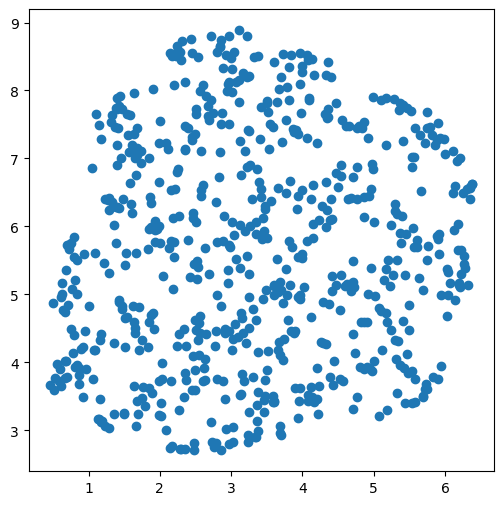

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(x=user_embed_umap_2d[:,0], y=user_embed_umap_2d[:,1])
plt.show()

### Encoding & Scaling data

In [12]:
user_encoder, movie_encoder = LabelEncoder(), LabelEncoder()
scaler = StandardScaler()

In [13]:
user_df['userId'] = user_encoder.fit_transform(user_df['userId'])
movie_df['movieId'] = movie_encoder.fit_transform(movie_df['movieId'])

rating_df['userId'] = user_encoder.transform(rating_df['userId'])
rating_df['movieId'] = movie_encoder.transform(rating_df['movieId'])

In [14]:
features_to_scale = ['imdbRating', 'imdbVotes', 'runtime', 'year']
scaled_features = scaler.fit_transform(movie_df[features_to_scale])
scaled_features_df = pd.DataFrame(scaled_features, columns=features_to_scale)

In [15]:
movie_df.drop(columns=features_to_scale, axis=1, inplace=True)
movie_df = pd.concat([movie_df, scaled_features_df], axis=1)
movie_df.head()

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,1.528928,5.144229,-0.876122,0.158905
1,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0.174897,1.394602,-0.058951,0.158905
2,2,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,-0.115253,-0.318207,-0.165539,0.158905
3,3,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,-1.082418,-0.426889,0.651632,0.158905
4,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,-0.792268,-0.248423,0.012107,0.158905


### Create Pytorch Geometric (heterogenious) Dataset

In [16]:
def create_data_set(kind:str) -> dict:
    if kind == 'OH': 
        x_user = torch.eye(len(user_df['userId'].values))
    elif kind == 'Embedding':
        x_user = torch.Tensor(user_embeddings)
    else:
        raise KeyError('Kind must be either "OH" or "Embedding"')

    x_movie = movie_df.drop(columns=['movieId'], axis=1)
    x_movie = torch.Tensor(x_movie.values)
    x_movie.size()

    edge_index = torch.Tensor(rating_df[['userId', 'movieId']].values).swapaxes(1,0).to(torch.long)
    edge_index.size(), edge_index

    edge_label = torch.Tensor(rating_df['rating'].values)
    edge_label.size(), edge_label

    data = HeteroData()
    data['user'].x = x_user
    data['movie'].x = x_movie

    data[('user', 'rates', 'movie')].edge_index = edge_index
    data[('user', 'rates', 'movie')].edge_label = edge_label

    data = ToUndirected()(data)
    del data[('movie', 'rev_rates', 'user')].edge_label

    return data.to(device)

oh_dataset = create_data_set(kind='OH')
embed_dataset = create_data_set(kind='Embedding')

print('OH Dataset:', oh_dataset)
print('Embedding Dataset:', embed_dataset)

OH Dataset: HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)
Embedding Dataset: HeteroData(
  user={ x=[671, 8] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)


### GNN Model

In [17]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin_out = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        z = self.lin_out(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels, data):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


oh_model = Model(hidden_channels=64, data=oh_dataset).to(device)
embed_model = Model(hidden_channels=64, data=embed_dataset).to(device)

In [18]:
def train(model, optimizer, train_data):
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = F.mse_loss(pred, target).sqrt()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [19]:
def compare(data, n_cv_folds=10, n_epochs=300):
    """ Compares loss and training time between one-hot user encoding 
        and user embeddings (8 dim). """

    comp_val_losses, comp_train_time = [], []
    for i in range(n_cv_folds):

        # Train/Test Splitting
        train_data, val_data, test_data = RandomLinkSplit(
            num_val=0.1,
            num_test=0.1,
            neg_sampling_ratio=0.0,
            edge_types=[('user', 'rates', 'movie')],
            rev_edge_types=[('movie', 'rev_rates', 'user')],
        )(data)

        # Model
        model = Model(hidden_channels=64, data=data).to(device)

        # Lazy init
        with torch.no_grad():
            model.encoder(train_data.x_dict, train_data.edge_index_dict)

        optimizer = torch.optim.Adam(model.parameters())

        # Training
        train_losses, val_losses, test_losses = [], [], []
        train_time_start = datetime.now()
        for epoch in range(1, n_epochs+1):
            train_loss = train(model, optimizer, train_data)
            val_rmse = test(model, val_data)
            test_rmse = test(model, test_data)
            
            train_losses.append(train_loss), val_losses.append(val_rmse), test_losses.append(test_rmse)
            
            if i+1 == n_epochs:
                print(f'Epoch: {epoch:03d}\tTrain: {train_loss:.4f}\t'
                    f'Val: {val_rmse:.4f}\tTest: {test_rmse:.4f}')

        train_time_end = datetime.now()
        train_elapsed = train_time_end - train_time_start
        
        comp_val_losses.append(val_losses)
        comp_train_time.append(train_elapsed)

    return comp_val_losses, comp_train_time

oh_val_losses, oh_train_times = compare(oh_dataset)
embed_val_losses, embed_train_times = compare(embed_dataset)

In [20]:
len(oh_val_losses), len(oh_val_losses[0])

(10, 300)

(300,)


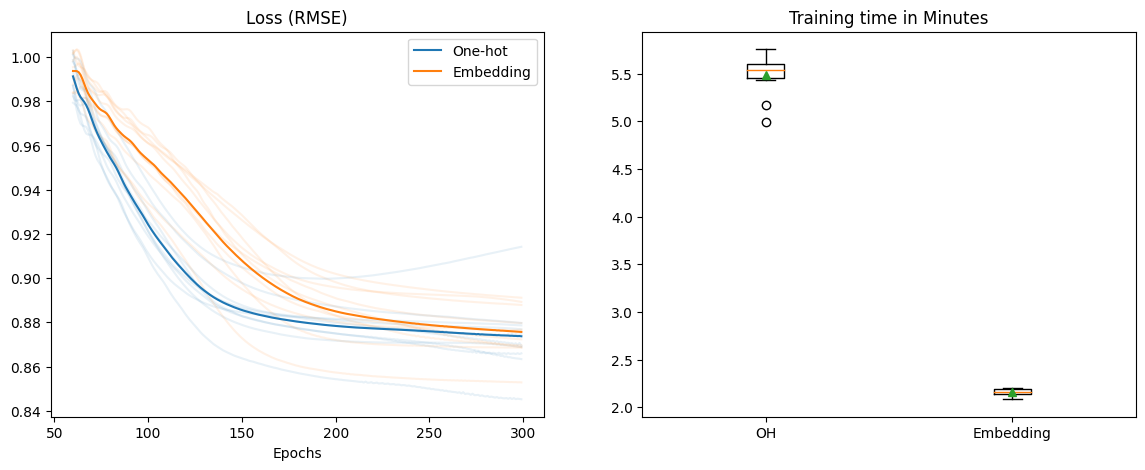

In [21]:
SKIP_WARM_UP_STEPS = 60
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
x_axis = range(SKIP_WARM_UP_STEPS, len(oh_val_losses[0]))

# plot cv results
for oh_loss, embed_loss in zip(oh_val_losses, embed_val_losses):
    ax0.plot(x_axis, oh_loss[SKIP_WARM_UP_STEPS:], c='C0', alpha=0.1)
    ax0.plot(x_axis, embed_loss[SKIP_WARM_UP_STEPS:], c='C1', alpha=0.1)

# mean values
oh_losses_mean = np.mean(np.array(oh_val_losses), axis=0)
embed_losses_mean = np.mean(np.array(embed_val_losses), axis=0)
print(oh_losses_mean.shape)
ax0.plot(x_axis, oh_losses_mean[SKIP_WARM_UP_STEPS:], c='C0', label='One-hot')
ax0.plot(x_axis, embed_losses_mean[SKIP_WARM_UP_STEPS:], c='C1', label='Embedding')

# print(t.total_seconds() / 60)
train_times = []
train_times.append([t.total_seconds() / 60 for t in oh_train_times])
train_times.append([t.total_seconds() / 60 for t in embed_train_times])
ax1.boxplot(train_times, labels=['OH', 'Embedding'], showmeans=True)

ax0.set_title('Loss (RMSE)')
ax0.set_xlabel('Epochs')
ax1.set_title('Training time in Minutes')

ax0.legend()
plt.show()